# 目錄

- [1.資料匯入，整理](#資料匯入整理)    
- [1.1CSV](#csv)    
- [1.2yahoo](#yahoo)


- [2.穿透次數](#穿透次數)


- [3.method](#method)    
- [3.1歷史模擬法](#歷史模擬法)        
- [3.1.1排序方法](#排序方法)        
- [3.1.2歷史模擬法函數](#歷史模擬法函數) 


- [3.2變異數(簡單)(指數)估算](#變異數簡單指數估算) 


- [3.3變異數_共變異數法](#變異數_共變異數法)  


- [3.4蒙地卡羅法](#蒙地卡羅法)        
- [3.4.1ndarray計算](#ndarray計算)        
- [3.4.2蒙地卡羅法函數](#蒙地卡羅法函數)


- [4.整合](#整合)


# 資料匯入，整理

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime 
# 繪圖格式設定
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['axes.unicode_minus']=False # 負號正常顯示
plt.rcParams['font.family']='DFKai-sb' # 'DFKai-sb' :標楷體 

# pandas web 爬雅虎的修正
import fix_yahoo_finance as yf
# 測試
yf.pdr_override()

start = datetime(2017, 6, 14)
end = datetime(2018, 6, 14)
 
df = yf.download(['2330.TW'], start, end)

df['Close'].plot()

[*********************100%***********************]  1 of 1 downloaded


## CSV

In [2]:
def download_from_csv(name):
    '''
    抓取CSV檔
    同目錄的.csv有以下
    [1201,2409,2884]
    
    資料期間: 2013~2015(共3年)
    
    input:
        name: 股票名稱，[1201,2409,2884]
        
    output:
        data: ['Close','return']共3年
        data_Forecast: ['Close','return'] 2015當年
        num_For: 2015當年資料長度
        num_his: 前兩年(計算所需)的資料長度
    
    '''
    data = pd.read_csv(name+'.csv',index_col=[0],parse_dates=[0])
    data['return'] = data['close'].pct_change()
    data_Forecast = data[data.index.year == 2015]
    
    num_For = data_Forecast.shape[0]
    num_his = data.shape[0] - num_For
    
    return(
        data,
        data_Forecast,
        num_For,
        num_his
    )

#(data, data_Forecast, num_For, num_his) = download_from_csv(name='2884')

In [3]:
(data, data_Forecast, num_For, num_his) = download_from_csv(name='2884')

## yahoo

In [4]:
def download_from_yahoo(name, year=2015):
    '''
    抓取YAHOO的資料
    含需回測風險值的年份，以及前兩年(計算所需)，
    共3年
    
    input:
        name: 股票名稱
        year:需回測風險值的年份
        
    output:
        data: ['Adj Close','return']共3年
        data_Forecast: ['Adj Close','return'] year當年
        num_For: year當年資料長度
        num_his: 前兩年(計算所需)的資料長度
    '''
    
    start = datetime(year-2,1,1) # 開始日期
    end = datetime(year,12,31) # 結束日期
    
    df = yf.download([name+'.TW'], start, end)
    df=df.loc[df['Volume']>0] # yahoo的資料有些錯誤(如:國定假日)
    df['return'] = df['Adj Close'].pct_change()
    data = df.loc[:,['Adj Close','return']]
    data_Forecast = data[data.index.year == 2015]
    
    num_For = data_Forecast.shape[0]
    num_his = data.shape[0] - num_For
    
    return(data, data_Forecast, num_For, num_his)

# (data, data_Forecast, num_For, num_his) = download_from_yahoo(name='2884')

In [5]:
(data, data_Forecast, num_for, num_his) = download_from_yahoo(name='2884')

[*********************100%***********************]  1 of 1 downloaded


# 穿透次數

理論上的穿透次數 = alpha*預測期長度

各方法(歷史模擬法、變異數_共變異數法、蒙地卡羅法)的穿透次數越符合理論穿透次數越是好的風險值衡量方式，

但極端事件仍難以預防(如:2008年金融風暴)

In [6]:
# 理論穿透次數
# alpha=0.05
num_for*0.05

12.200000000000001

# method

## 歷史模擬法

分析之資產需有大量歷史資料，才有辦法精確地敘述極端狀況下的風險值

將可能報酬由小至大排序，依據不同$\alpha$取值。以100筆損益資料為例，若$\alpha$=0.05，則第5筆資料(100*0.05=5)即為估算之風險值。

**條件風險值**

以100筆損益資料為例，若$\alpha$=0.05，則獎第5筆前的資料加總後平均

### 排序方法

**以下為排序的方法(取第幾{num}小)**

In [7]:
arr = np.array([46, 57, 23, 39, 1, 10, 0, 120])

def sort_num(arr, num):
    '''
    對數組(arr)排序直到,序位{num}(0...num) 
    '''
    r = arr[np.argpartition(arr, num)[num]]
    return r

def sort_num_sum(arr, num):
    '''
    對數組(arr)排序直到,序位{num},並選取{[:num+1]]}(0...num),作加總
    '''
    r = arr[np.argpartition(arr, num)[:num+1]].sum() 
    return  r

print(f'數組arr: \n {arr} \n')
print(f'對數組arr排序:\n {np.sort(arr)} \n')
print(f'對數組(arr)排序直到,序位2(0.1.2)')
sort_num(arr=arr, num=2)
print(f'對數組(arr)排序直到,序位2,並加總')
sort_num_sum(arr=arr, num=2)
    


數組arr: 
 [ 46  57  23  39   1  10   0 120] 

對數組arr排序:
 [  0   1  10  23  39  46  57 120] 

對數組(arr)排序直到,序位2(0.1.2)


10

對數組(arr)排序直到,序位2,並加總


11

### 歷史模擬法函數

In [8]:
def hist_method(data, data_Forecast, num_his, alpha):
    '''
    歷史模擬法
    
    input:
        data: ['Close','return']共3年
        data_Forecast: ['Close','return'] 預測期當年
        num_his: 前兩年(計算所需)的資料長度
        alpha: alpha值 [0.01,0.05]
        
    output:
        data_hist: 風險值資料(歷史模擬法)
        dis_VaR: VaR穿透數
        dis_CVaR: CVaR穿透數
    '''
    
    # num:排序序位 ; 由於排序函數(sort_num,sort_num_sum)，
    # 的序位均由 0 開始，因此 -1
    num = int((num_his-1)*alpha) - 1
    # 避免干擾源資料
    data_hist = data_Forecast[:]
    
    # @ 排序函數
    def sort_num(arr, num):
        '''
        對數組(arr)排序直到,序位{num}(0...num) 
        '''
        r = arr[np.argpartition(arr, num)[num]]
        return r

    def sort_num_sum(arr, num):
        '''
        對數組(arr)排序直到,序位{num},並選取{[:num+1]]}(0...num),作加總
        '''
        r = arr[np.argpartition(arr, num)[:num+1]].sum() 
        return  r
    
    # 風險值計算
    # rolling: 移動視窗，用過去資料，評斷未來，大小為 num_his(0...num_his-1)
    data_hist['VaR'] = data.loc[:,['return']].rolling(num_his-1).apply(
        lambda arr: sort_num(arr, num),
        # raw=True 向函數(lambda)傳送 ndarray
        raw=True
    # shift(1): 數據向後移一天 # dropna():去除 nan
    ).shift(1).dropna()
    
    # 條件風險值計算
    data_hist['CVaR'] =  data.loc[:,['return']].rolling(num_his-1).apply(
        # ex:序位2(0.1.2)，實際總數為 3，故 +1
        lambda arr: sort_num_sum(arr, num)/(num+1),
        raw=True
    ).shift(1).dropna()

    data_hist = data_hist.loc[:,['return','VaR','CVaR']]
    # VaR穿透數
    dis_VaR = data_hist[data_hist['return'] < data_hist['VaR']].shape[0]
    # CVaR穿透數
    dis_CVaR = data_hist[data_hist['return'] < data_hist['CVaR']].shape[0]
    
    return(data_hist, dis_VaR, dis_CVaR)

D:\anaconda\lib\site-packages\ipykernel\__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\anaconda\lib\site-packages\ipykernel\__main__.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


VaR穿透數:22
CVaR穿透數:6


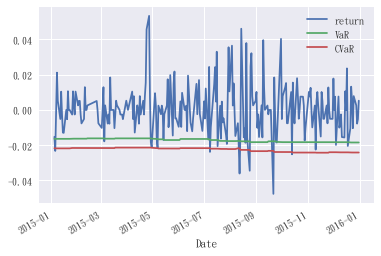

In [9]:
(data_hist, dis_VaR, dis_CVaR) = hist_method(data, data_Forecast, num_his, alpha=0.05)

data_hist.plot()
print(f'VaR穿透數:{dis_VaR}\nCVaR穿透數:{dis_CVaR}')

## 變異數(簡單)(指數)估算

**變異數的估算**

傳統上通常利用移動平均的觀念來估算變異數，並且可進一步分為等權移動平均與指數加權移動平均兩種方式。

* 等權移動平均(簡單)

$$ \sigma_{t} = \sqrt{\sum\frac{(R_{t}-\bar{R})^2}{T-1}} $$

* 加權移動平均(指數)

$$ \sigma_{t} = \sqrt{\lambda\sigma^2_{t-1} + (1-\lambda R_{t}^2)} $$

($\lambda$≤1 表示衰退因子, 目的為在使早期的變異數對於當期波動性影響程度隨$\lambda$值愈小而降低)

$\lambda$：衰退因子(0.94，因使用日資料，月資料為0.97)


In [10]:
def sigma_method(data, num_his, method='sample'):
    '''
    變異數(sigma)的估算
    
    input:
        data: ['Close','return']共3年
        num_his: 前兩年(計算所需)的資料長度
        method: 分為'sample'(簡單)，'weighted'(指數)
        
    output:
        sigma: method == 'sample' -> sample_sigma
                method == 'weighted' -> weighted_sigma
    
    '''
    
    # 變異數(簡單)
    if method == 'sample':
        sample_sigma = data.loc[:,['return']].rolling(num_his-1).apply(
            lambda arr: np.std(arr), 
            raw=True
        ).shift(1).dropna()

        return sample_sigma
    # 變異數(指數)
    elif method == 'weighted':
        # 需用前一筆變異數(簡單)，故 num_his-2
        sample_sigma = data.loc[:,['return']].rolling(num_his-2).apply(
            lambda arr: np.std(arr), 
            raw=True
        )
        # 加權移動平均(指數)
        weighted_sigma = (
            0.94*sample_sigma.shift(1)**2 + (1-0.94)*data.loc[:,['return']].iloc[num_his-1:,:]**2
        )**0.5

        return weighted_sigma.shift(1).dropna()

## 變異數_共變異數法

假設個別資產報酬率符合聯合常態分配，而且具有序列獨立的特性，藉由常態分配的性質，可快速估算評估期間的風險值

W(價值)設為1，僅考慮變化

$$ VaR = -Z\sigma W $$

$\alpha$=0.05 -> Z=1.645

$\alpha$=0.01 -> Z=2.33

**條件風險值**

$$ ES = \frac{1}{\alpha}[-\frac{\sigma}{\sqrt{2\pi}}exp(-\frac{(-VaR_{\alpha})^2}{2\sigma^2})] $$

In [11]:

def cm_method(data, data_Forecast, num_his, method='sample', alpha=0.05):
    '''
    變異數_共變異數法
    
    input:
        data: ['Close','return']共3年
        data_Forecast: ['Close','return'] 預測期當年
        num_his: 前兩年(計算所需)的資料長度
        method: 調用sigma_method函數，'sample' OR 'weighted'
        alpha: alpha值 [0.01,0.05]
        
    output:
        data_cm: 風險值資料(變異數_共變異數法)
        dis_VaR: VaR穿透數
        dis_CVaR: CVaR穿透數
    '''
    
    if alpha == 0.05:
        z=1.645
    elif alpha == 0.01:
        z=2.33
    
    data_cm = data_Forecast[:]
    
    sigma = sigma_method(data, num_his, method=method)

    data_cm['VaR'] = -z*sigma*1
    data_cm['CVaR'] = (1/alpha)*-(sigma/((2*np.pi)**0.5))*np.exp(-((-z*sigma*1)**2)/(2*(sigma**2)))
    
    dis_VaR = data_cm[data_cm['return'] < data_cm['VaR']].shape[0]
    dis_CVaR = data_cm[data_cm['return'] < data_cm['CVaR']].shape[0]
    
    data_cm = data_cm.loc[:,['return','VaR','CVaR']]
    
    return(data_cm, dis_VaR, dis_CVaR)


D:\anaconda\lib\site-packages\ipykernel\__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\anaconda\lib\site-packages\ipykernel\__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


VaR穿透數:16
CVaR穿透數:6


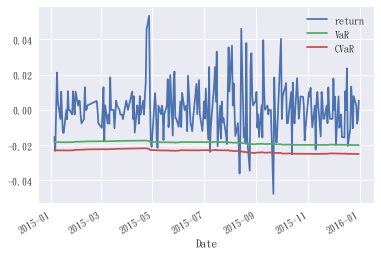

In [12]:
(data_cm, dis_VaR, dis_CVaR) = cm_method( data, data_Forecast, num_his, method='sample', alpha=0.05)

data_cm.plot()

print(f'VaR穿透數:{dis_VaR}\nCVaR穿透數:{dis_CVaR}')

## 蒙地卡羅法

是一種隨機模擬方法，以概率和統計理論方法為基礎的一種計算方法，是使用隨機數（或更常見的偽隨機數）來解決很多計算問題的方法，基於大數法則的實證方法，當實驗的次數越多，平均值會越接近理論值。

分成t期

$S_{t-1}$到$S_{t}$的關係式

$$ S_{t} = S_{t-1}exp\left[(\mu-\frac{\sigma^2}{2}\Delta t+\sqrt{\Delta t}\epsilon)\right] $$

其中$\mu$是股價平均數，$\epsilon$是符合常態N(0,1)的隨機數

移項取$\ln$得到$S_{0}$到$S_{t}$的$return$:

$$ return \simeq \ln\frac{S_{t}}{S_{0}} = \sum_{n=1}^{t}\left[(\mu-\frac{\sigma^2}{2}\Delta t+\sqrt{\Delta t}\epsilon)\right] $$

基於大數法則，計算N條不同隨機數，所得到的$return$，排序後選擇第N*$\alpha$筆(和歷史模擬法類似)

**條件風險值**

排序後選擇前N*$\alpha$筆(和歷史模擬法類似)加總後平均

### ndarray計算

以下為 ndarray的廣播(3,4,5)*(5,)、多維排序加總(對特定軸[ex: axis=1])

In [13]:
a = np.ones(shape=(3,4,5))

b = a*[0,1,10,20,40]
print(f'#shape (3,4,5)*(5,): \n {b} \n 成立(反過來亦成立 (5,)*(3,4,5)) \n ')
b_sum = b.sum(axis=1)
print(f'#對axis=1軸作加總(b_sum): \n {b_sum}')

c = b_sum*[[1,30,1,1,1],[1,1,10,1,1],[1,1,1,10,1]]
print(f'#製造差異(c): \n {c}')


#shape (3,4,5)*(5,): 
 [[[ 0.  1. 10. 20. 40.]
  [ 0.  1. 10. 20. 40.]
  [ 0.  1. 10. 20. 40.]
  [ 0.  1. 10. 20. 40.]]

 [[ 0.  1. 10. 20. 40.]
  [ 0.  1. 10. 20. 40.]
  [ 0.  1. 10. 20. 40.]
  [ 0.  1. 10. 20. 40.]]

 [[ 0.  1. 10. 20. 40.]
  [ 0.  1. 10. 20. 40.]
  [ 0.  1. 10. 20. 40.]
  [ 0.  1. 10. 20. 40.]]] 
 成立(反過來亦成立 (5,)*(3,4,5)) 
 
#對axis=1軸作加總(b_sum): 
 [[  0.   4.  40.  80. 160.]
 [  0.   4.  40.  80. 160.]
 [  0.   4.  40.  80. 160.]]
#製造差異(c): 
 [[  0. 120.  40.  80. 160.]
 [  0.   4. 400.  80. 160.]
 [  0.   4.  40. 800. 160.]]


In [14]:
print(f'排序目標(c): \n {c} \n ')
axis = 0
sort_num = 1

print(f'對 axis= {axis} 軸全排序直到 序位{sort_num}(0... {sort_num})')
np.argpartition(c, sort_num, axis=axis)

if axis == 0:
    another_axis = np.arange(c.shape[1])[None,:]
    print(f'另一軸(another_axis): \n {another_axis} \n')
    sort_status = np.argpartition(c, sort_num, axis=axis)
    top = sort_status[:sort_num+1, :]
    print(f'排序序位情形: \n {top} \n')
    d = c[top,another_axis].sum(axis=0)
    print(f'結果: \n {d} \n')
elif axis == 1:
    another_axis = np.arange(c.shape[0])[:, None]
    print(f'另一軸(another_axis): \n {another_axis} \n')
    top = np.argpartition(c, sort_num, axis=axis)[:, sort_num]
    print(f'排序序位情形: \n {top} \n')
    d = c[another_axis,top]
    print(f'結果: \n {d} \n')


排序目標(c): 
 [[  0. 120.  40.  80. 160.]
 [  0.   4. 400.  80. 160.]
 [  0.   4.  40. 800. 160.]] 
 
對 axis= 0 軸全排序直到 序位1(0... 1)


array([[0, 1, 0, 0, 0],
       [1, 2, 2, 1, 1],
       [2, 0, 1, 2, 2]], dtype=int64)

另一軸(another_axis): 
 [[0 1 2 3 4]] 

排序序位情形: 
 [[0 1 0 0 0]
 [1 2 2 1 1]] 

結果: 
 [  0.   8.  80. 160. 320.] 



### 蒙地卡羅法函數

In [15]:

def mote_method(data, data_Forecast, num_his, method='sample', alpha=0.05):
    '''
    蒙地卡羅法
    
    input:
        data: ['Close','return']共3年
        data_Forecast: ['Close','return'] 預測期當年
        num_his: 前兩年(計算所需)的資料長度
        method: 調用sigma_method函數，'sample' OR 'weighted'
        alpha: alpha值 [0.01,0.05]
        
    output:
        data_mote: 風險值資料(蒙地卡羅法)
        dis_VaR: VaR穿透數
        dis_CVaR: CVaR穿透數
    
    '''
    
    t = 10 # 分成t期
    N = 1000 # N條不同路徑(隨機數)
    
    data_mote = data_Forecast[:]
    
    sigma = sigma_method(data, num_his , method=method)['return'].values
    # 股價平均數
    u = data['return'].rolling(num_his-1).mean().shift(1).dropna().values
    # 隨機數
    er = np.random.randn(N,t,len(u))
    # N條不同隨機數的 return
    mt_var_N = ((u-(sigma**2)/2)*(1/t)+sigma*((1/t)**0.5)*er).sum(axis=1)

    axis = 0
    sort_num = int(N*alpha) - 1
    # 另一軸
    another_axis = np.arange(mt_var_N.shape[1])[None,:]
    # 排序序位情形
    sort_status = np.argpartition(mt_var_N, sort_num, axis=axis)
    top = sort_status[sort_num, :]
    # [:sort_num+1, :]，對 axis=0 取到 num(0...num)
    top_for_sum = sort_status[:sort_num+1, :]
    
    data_mote['VaR'] = mt_var_N[top,another_axis].ravel()
    data_mote['CVaR'] = (
        mt_var_N[top_for_sum,another_axis].sum(axis=axis)/(sort_num+1)
    ).ravel()
    
    data_mote = data_mote.loc[:,['return','VaR','CVaR']]
    
    dis_VaR = data_mote[data_mote['return'] < data_mote['VaR']].shape[0]
    dis_CVaR = data_mote[data_mote['return'] < data_mote['CVaR']].shape[0]
    
    return(data_mote, dis_VaR, dis_CVaR)
    
    
    

D:\anaconda\lib\site-packages\ipykernel\__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\anaconda\lib\site-packages\ipykernel\__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


VaR穿透數:14
CVaR穿透數:8


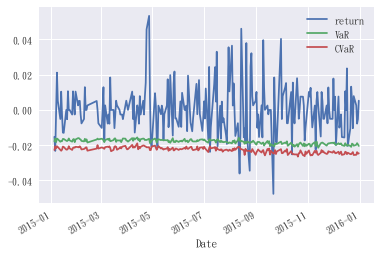

In [16]:
(data_mote, dis_VaR, dis_CVaR) = mote_method(data, data_Forecast, num_his, method='sample', alpha=0.05)

data_mote.plot()

print(f'VaR穿透數:{dis_VaR}\nCVaR穿透數:{dis_CVaR}')

# 整合

[*********************100%***********************]  1 of 1 downloaded
理論穿透:12.2
VaR穿透數:15
CVaR穿透數:8


D:\anaconda\lib\site-packages\ipykernel\__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\anaconda\lib\site-packages\ipykernel\__main__.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


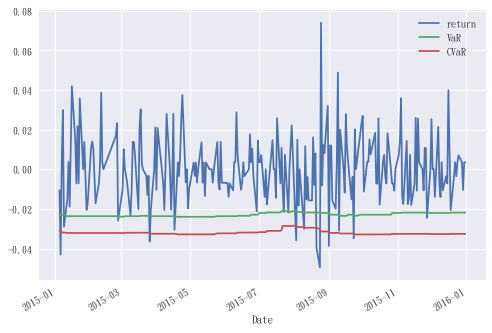

In [19]:
import numpy as np
import pandas as pd

# 繪圖格式設定
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['axes.unicode_minus']=False # 負號正常顯示
plt.rcParams['font.family']='DFKai-sb' # 'DFKai-sb' :標楷體 

from datetime import datetime 
# pandas web 爬雅虎的修正
import fix_yahoo_finance as yf
# 測試
yf.pdr_override()

class VaR:
    # @staticmethod 裝飾器 無須實例化即可調用
    
    @staticmethod
    def download_from_yahoo(name, year=2015):
        '''
        抓取YAHOO的資料
        含需回測風險值的年份，以及前兩年(計算所需)，
        共3年

        input:
            name: 股票名稱
            year:需回測風險值的年份

        output:
            data: ['Adj Close','return']共3年
            data_Forecast: ['Adj Close','return'] year當年
            num_For: year當年資料長度
            num_his: 前兩年(計算所需)的資料長度
        '''

        start = datetime(year-2,1,1) # 開始日期
        end = datetime(year,12,31) # 結束日期

        df = yf.download([name+'.TW'], start, end)
        df=df.loc[df['Volume']>0] # yahoo的資料有些錯誤(如:國定假日)
        df['return'] = df['Adj Close'].pct_change()
        data = df.loc[:,['Adj Close','return']]
        data_Forecast = data[data.index.year == 2015]

        num_For = data_Forecast.shape[0]
        num_his = data.shape[0] - num_For
    
        return(data, data_Forecast, num_For, num_his)
    
    
    @staticmethod
    def hist_method(data, data_Forecast, num_his, alpha):
        '''
        歷史模擬法

        input:
            data: ['Close','return']共3年
            data_Forecast: ['Close','return'] 預測期當年
            num_his: 前兩年(計算所需)的資料長度
            alpha: alpha值 [0.01,0.05]

        output:
            data_hist: 風險值資料(歷史模擬法)
            dis_VaR: VaR穿透數
            dis_CVaR: CVaR穿透數
        '''

        # num:排序序位 ; 由於排序函數(sort_num,sort_num_sum)，
        # 的序位均由 0 開始，因此 -1
        num = int((num_his-1)*alpha) - 1
        # 避免干擾源資料
        data_hist = data_Forecast[:]

        # @ 排序函數
        def sort_num(arr, num):
            '''
            對數組(arr)排序直到,序位{num}(0...num) 
            '''
            r = arr[np.argpartition(arr, num)[num]]
            return r

        def sort_num_sum(arr, num):
            '''
            對數組(arr)排序直到,序位{num},並選取{[:num+1]]}(0...num),作加總
            '''
            r = arr[np.argpartition(arr, num)[:num+1]].sum() 
            return  r

        # 風險值計算
        # rolling: 移動視窗，用過去資料，評斷未來，大小為 num_his(0...num_his-1)
        data_hist['VaR'] = data.loc[:,['return']].rolling(num_his-1).apply(
            lambda arr: sort_num(arr, num),
            # raw=True 向函數(lambda)傳送 ndarray
            raw=True
        # shift(1): 數據向後移一天 # dropna():去除 nan
        ).shift(1).dropna()

        # 條件風險值計算
        data_hist['CVaR'] =  data.loc[:,['return']].rolling(num_his-1).apply(
            # ex:序位2(0.1.2)，實際總數為 3，故 +1
            lambda arr: sort_num_sum(arr, num)/(num+1),
            raw=True
        ).shift(1).dropna()

        data_hist = data_hist.loc[:,['return','VaR','CVaR']]
        # VaR穿透數
        dis_VaR = data_hist[data_hist['return'] < data_hist['VaR']].shape[0]
        # CVaR穿透數
        dis_CVaR = data_hist[data_hist['return'] < data_hist['CVaR']].shape[0]

        return(data_hist, dis_VaR, dis_CVaR)
    
    
    @staticmethod
    def sigma_method(data, num_his, method='sample'):
        '''
        變異數(sigma)的估算

        input:
            data: ['Close','return']共3年
            num_his: 前兩年(計算所需)的資料長度
            method: 分為'sample'(簡單)，'weighted'(指數)

        output:
            sigma: method == 'sample' -> sample_sigma
                    method == 'weighted' -> weighted_sigma

        '''

        # 變異數(簡單)
        if method == 'sample':
            sample_sigma = data.loc[:,['return']].rolling(num_his-1).apply(
                lambda arr: np.std(arr), 
                raw=True
            ).shift(1).dropna()

            return sample_sigma
        # 變異數(指數)
        elif method == 'weighted':
            # 需用前一筆變異數(簡單)，故 num_his-2
            sample_sigma = data.loc[:,['return']].rolling(num_his-2).apply(
                lambda arr: np.std(arr), 
                raw=True
            )
            # 加權移動平均(指數)
            weighted_sigma = (
                0.94*sample_sigma.shift(1)**2 + (1-0.94)*data.loc[:,['return']].iloc[num_his-1:,:]**2
            )**0.5

            return weighted_sigma.shift(1).dropna()
        
        
    @staticmethod
    def cm_method(data, data_Forecast, num_his, method='sample', alpha=0.05):
        '''
        變異數_共變異數法

        input:
            data: ['Close','return']共3年
            data_Forecast: ['Close','return'] 預測期當年
            num_his: 前兩年(計算所需)的資料長度
            method: 調用sigma_method函數，'sample' OR 'weighted'
            alpha: alpha值 [0.01,0.05]

        output:
            data_cm: 風險值資料(變異數_共變異數法)
            dis_VaR: VaR穿透數
            dis_CVaR: CVaR穿透數
        '''

        if alpha == 0.05:
            z=1.645
        elif alpha == 0.01:
            z=2.33

        data_cm = data_Forecast[:]

        sigma = self.sigma_method(data, num_his, method=method)

        data_cm['VaR'] = -z*sigma*1
        data_cm['CVaR'] = (1/alpha)*-(sigma/((2*np.pi)**0.5))*np.exp(-((-z*sigma*1)**2)/(2*(sigma**2)))

        dis_VaR = data_cm[data_cm['return'] < data_cm['VaR']].shape[0]
        dis_CVaR = data_cm[data_cm['return'] < data_cm['CVaR']].shape[0]

        data_cm = data_cm.loc[:,['return','VaR','CVaR']]

        return(data_cm, dis_VaR, dis_CVaR)
    
    
    @staticmethod
    def mote_method(data, data_Forecast, num_his, method='sample', alpha=0.05):
        '''
        蒙地卡羅法

        input:
            data: ['Close','return']共3年
            data_Forecast: ['Close','return'] 預測期當年
            num_his: 前兩年(計算所需)的資料長度
            method: 調用sigma_method函數，'sample' OR 'weighted'
            alpha: alpha值 [0.01,0.05]

        output:
            data_mote: 風險值資料(蒙地卡羅法)
            dis_VaR: VaR穿透數
            dis_CVaR: CVaR穿透數

        '''

        t = 10 # 分成t期
        N = 1000 # N條不同路徑(隨機數)

        data_mote = data_Forecast[:]

        sigma = self.sigma_method(data, num_his , method=method)['return'].values
        # 股價平均數
        u = data['return'].rolling(num_his-1).mean().shift(1).dropna().values
        # 隨機數
        er = np.random.randn(N,t,len(u))
        # N條不同隨機數的 return
        mt_var_N = ((u-(sigma**2)/2)*(1/t)+sigma*((1/t)**0.5)*er).sum(axis=1)

        axis = 0
        sort_num = int(N*alpha) - 1
        # 另一軸
        another_axis = np.arange(mt_var_N.shape[1])[None,:]
        # 排序序位情形
        sort_status = np.argpartition(mt_var_N, sort_num, axis=axis)
        top = sort_status[sort_num, :]
        # [:sort_num+1, :]，對 axis=0 取到 num(0...num)
        top_for_sum = sort_status[:sort_num+1, :]

        data_mote['VaR'] = mt_var_N[top,another_axis].ravel()
        data_mote['CVaR'] = (
            mt_var_N[top_for_sum,another_axis].sum(axis=axis)/(sort_num+1)
        ).ravel()

        data_mote = data_mote.loc[:,['return','VaR','CVaR']]

        dis_VaR = data_mote[data_mote['return'] < data_mote['VaR']].shape[0]
        dis_CVaR = data_mote[data_mote['return'] < data_mote['CVaR']].shape[0]

        return(data_mote, dis_VaR, dis_CVaR)
    
    
       
    def output(self, func):
        (data_result, dis_VaR, dis_CVaR) = func
        data_result.plot()
        dis = round(self.num_For*self.alpha,2)
        print(
            f'理論穿透:{dis}\n' + \
            f'VaR穿透數:{dis_VaR}\nCVaR穿透數:{dis_CVaR}'
        )
        
    
    def __init__(self, name='2330', year=2015, alpha=0.05, method='sample'):
        (self.data, self.data_Forecast, self.num_For, self.num_his) = self.download_from_yahoo(name, year)
        self.alpha = alpha
        self.method = 'sample' # for sigma_method: 'sample'(簡單)，'weighted'(指數)
        
        # 各個方法的函數
        self.method_func_dict = {
            '歷史模擬法':VaR.hist_method,
            '變異數_共變異數法':VaR.cm_method,
            '蒙地卡羅法':VaR.mote_method
        }
        # 各個方法的函數所需的參數
        self.method_agrs_dict = {
            '歷史模擬法':{
                'data': self.data,
                'data_Forecast': self.data_Forecast,
                'num_his': self.num_his, 
                'alpha': self.alpha
            },
            '變異數_共變異數法':{
                'data': self.data,
                'data_Forecast': self.data_Forecast,
                'num_his': self.num_his,
                'method':self.method,
                'alpha': self.alpha
            },
            '蒙地卡羅法':{
                'data': self.data,
                'data_Forecast': self.data_Forecast,
                'num_his': self.num_his,
                'method':self.method,
                'alpha': self.alpha
            }
        }
        
        
        
    def main(self, method_name='歷史模擬法'):
        self.output(
            func = self.method_func_dict[method_name](
                **self.method_agrs_dict[method_name]
            )
        )
        
if __name__=='__main__':
    a = VaR(name='2330', year=2015, alpha=0.05, method='sample')
    a.main(method_name='歷史模擬法')
    

In [27]:
a.method_func_dict.keys()


dict_keys(['歷史模擬法', '變異數_共變異數法', '蒙地卡羅法'])

理論穿透:12.2
VaR穿透數:12
CVaR穿透數:8


D:\anaconda\lib\site-packages\ipykernel\__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\anaconda\lib\site-packages\ipykernel\__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


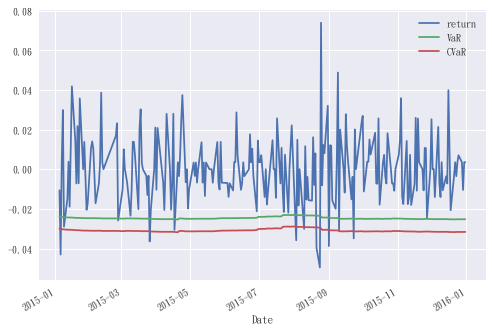

In [28]:
a.main(method_name='變異數_共變異數法')

D:\anaconda\lib\site-packages\ipykernel\__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\anaconda\lib\site-packages\ipykernel\__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


理論穿透:12.2
VaR穿透數:14
CVaR穿透數:9


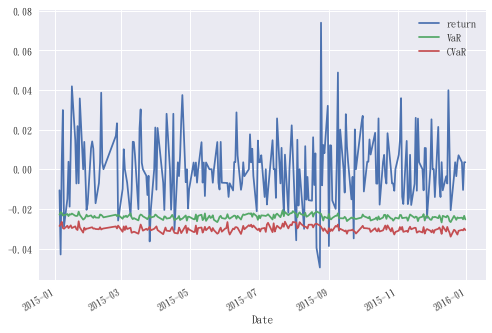

In [29]:
a.main(method_name='蒙地卡羅法')